In [24]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import zeros, newaxis
from evaluate_paddlepaddle import evaluate
from sklearn.preprocessing import MinMaxScaler

import keras
from data_loader import make_train_data, make_val_data, make_test_data, generate_dataset
from preprocess import preprocess
from keras import Input
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Bidirectional, TimeDistributed,RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)


In [177]:
SEQ_LEN = 2
BATCH_SIZE = 256 
EPOCHS = 1000

In [53]:
# Load dataset
full_data = pd.read_csv("data/wtbdata_245days.csv")
train_data = pd.read_csv("data/train_data.csv")
submission = pd.read_csv("data/sample_submission.csv")
test_data = pd.read_csv("info/target.csv")
full_data = full_data.fillna(method = 'bfill')
train_data = train_data.fillna(method = 'bfill')
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4727520 entries, 0 to 4727519
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 468.9+ MB


In [123]:
# Preprocessing
full_data = preprocess(full_data)

AttributeError: 'float' object has no attribute 'split'

In [124]:
data = full_data.copy()

In [125]:
location_data = pd.read_csv("data/turb_location.csv").set_index('TurbID')
location_dict = location_data.to_dict('index')
data['X'] = data['TurbID'].apply(lambda x: location_dict[x]['x'])
data['Y'] = data['TurbID'].apply(lambda y: location_dict[y]['y'])

In [126]:
data = data[['TurbID','Day','RPM', 'Bspd1', 'Bspd3', 'Bspd2', 'Wspd_cos', 'Wspd', 'Wspd_cube',
       'P_max', 'Pab1', 'Pab2', 'Pab3', 'TSR1', 'TSR2', 'TSR3', 'Prtv','Patv']]

In [127]:
data

,TurbID,Day,RPM,Bspd1,Bspd3,Bspd2,Wspd_cos,Wspd,Wspd_cube,P_max,Pab1,Pab2,Pab3,TSR1,TSR2,TSR3,Prtv,Patv
0,1,1,16.034441,16.034441,16.034441,16.034441,6.155045,6.17,233.181313,0.857621,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.25,494.66
1,1,1,16.034441,16.034441,16.034441,16.034441,6.155045,6.17,233.181313,0.857621,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.25,494.66
2,1,1,16.322087,16.322087,16.322087,16.322087,6.265462,6.27,245.957079,0.900427,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.24,509.76
3,1,1,16.723314,16.723314,16.723314,16.723314,6.419479,6.42,264.544863,0.966892,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.26,542.53
4,1,1,16.279842,16.279842,16.279842,16.279842,6.249246,6.25,244.052275,0.892196,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4727515,134,245,15.931622,15.931622,15.931622,15.931622,7.780700,7.79,471.038039,1.944747,6.03,6.03,6.03,2.047582,2.047582,2.047582,-111.69,601.44
4727516,134,245,16.616593,16.616593,16.616593,16.616593,8.036353,8.06,519.011538,2.151395,5.81,5.81,5.81,2.067678,2.067678,2.067678,-72.67,673.79
4727517,134,245,21.388748,21.388748,21.388748,21.388748,8.073603,8.08,526.262273,2.170929,0.68,0.68,0.68,2.649220,2.649220,2.649220,-118.70,999.36
4727518,134,245,23.216175,23.216175,23.216175,23.216175,8.459175,8.46,605.318689,2.491649,0.02,0.02,0.02,2.744496,2.744496,2.744496,-58.12,1100.89


In [128]:
train_data = data[data['Day']<201]

In [153]:
def make_test_data(data, seq_len):
    test_x, test_y = [], []
    for j in range(201, 240 - seq_len):
        test_days = np.arange(j, j+seq_len)
        label_days = np.arange(j+seq_len, j+seq_len+2)
        test_tmp = data[data.Day.isin(test_days)].drop(columns=['TurbID','Day'])
        label_tmp = data[data.Day.isin(label_days)].drop(columns=['TurbID','Day'])
        test_x.append(test_tmp)  # (720, 11) = (Tmstamp * days, n_features)
        test_y.append(label_tmp)  # (288)     = (Tmstamp * days)
    test_x, test_y = np.array(test_x, dtype=np.float32), np.array(test_y, dtype=np.float32)
    return np.array(test_x, dtype=np.float32), np.array(test_y, dtype=np.float32)

In [178]:
# Split data

train_x, train_y = make_train_data(train_data, SEQ_LEN)
# val_x,   val_y   = make_val_data(data, SEQ_LEN)
test_x, test_y   = make_test_data(data, SEQ_LEN)
# val_x,   val_y   = val_x.reshape(-1, *train_x.shape[1:]), val_y.reshape(-1, train_y.shape[1])
test_x, test_y   = test_x.reshape(-1, *train_x.shape[1:]),test_y.reshape(-1, *train_y.shape[1:])
print("Train data(X, y):", train_x.shape, train_y.shape)
# print("Val data(X, y):", val_x.shape, val_y.shape)
print("Test data(X, y):", test_x.shape, test_y.shape)

100%|██████████| 134/134 [00:55<00:00,  2.40it/s]


Train data(X, y): (26264, 288, 16) (26264, 288, 16)
Test data(X, y): (4958, 288, 16) (79328, 288)


In [182]:
# Generate dataset
train_ds = generate_dataset(train_x, train_y, batch_size=BATCH_SIZE)

In [183]:
test_ds = generate_dataset(test_x, test_y, batch_size=BATCH_SIZE)

In [ ]:
# # Modeling
# model = Sequential([
#     GRU(256,input_shape=train_x[0].shape),#, return_sequences=True
#     Dense(512, activation='relu'),
#     Dense((288*16), activation='relu')
# ])
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

In [193]:
model = Sequential(name="GRU-Model") # Model
model.add(Input(shape=(train_x.shape[1],train_x.shape[2]), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
model.add(Bidirectional(GRU(units=256, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-GRU-Encoder-Layer')) # Encoder Layer
model.add(RepeatVector(train_y.shape[1], name='Repeat-Vector-Layer')) # Repeat Vector
model.add(Bidirectional(GRU(units=256, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer')) # Decoder Layer
# model.add(RepeatVector(train_y.shape[1], name='Repeat-Vector-Layer2')) # Repeat Vector
model.add(TimeDistributed(Dense(units=16, activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x



In [194]:
model.summary()

Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-GRU-Encoder-Layer (B  (None, 512)              420864    
 idirectional)                                                   
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 288, 512)         0         
 Vector)                                                         
                                                                 
 Hidden-GRU-Decoder-Layer (B  (None, 288, 512)         1182720   
 idirectional)                                                   
                                                                 
 Output-Layer (TimeDistribut  (None, 288, 16)          8208      
 ed)                                                             
                                                                 
Total params: 1,611,792
Trainable params: 1,611,792
Non-t

In [195]:
##### Step 4 - Compile the model
model.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError', 'MeanAbsoluteError'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
              loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
              weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
              run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
              steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
             )

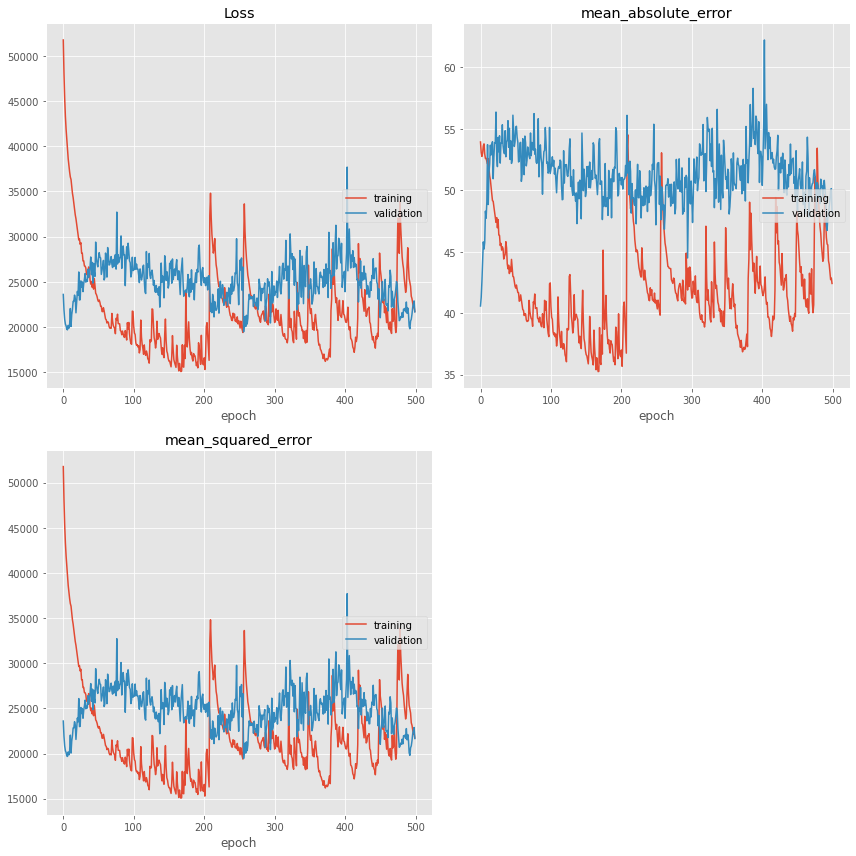

Loss
	training         	 (min: 15048.446, max: 51783.480, cur: 21717.094)
	validation       	 (min: 19452.674, max: 37703.113, cur: 21664.260)
mean_absolute_error
	training         	 (min:   35.250, max:   54.517, cur:   42.422)
	validation       	 (min:   40.587, max:   62.225, cur:   48.216)
mean_squared_error
	training         	 (min: 15048.444, max: 51783.488, cur: 21717.096)
	validation       	 (min: 19452.674, max: 37703.105, cur: 21664.262)
103/103 [==============================] - 19s 186ms/step - loss: 21717.0938 - mean_squared_error: 21717.0957 - mean_absolute_error: 42.4217 - val_loss: 21664.2598 - val_mean_squared_error: 21664.2617 - val_mean_absolute_error: 48.2164


INFO:tensorflow:Assets written to: saved_model/model_ep1000_b256_seq2_2022-07-12 19:35:25/assets


INFO:tensorflow:Assets written to: saved_model/model_ep1000_b256_seq2_2022-07-12 19:35:25/assets


In [197]:
# Training
from livelossplot import PlotLossesKeras
model.fit(train_ds, validation_data=test_ds, epochs=500, callbacks=[PlotLossesKeras()])#EarlyStopping(patience=10, restore_best_weights=True),
# model.fit(train_ds, epochs=50)#, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
now = datetime.now()
current_time = now.strftime('%Y-%m-%d %H:%M:%S')
model.save(f'saved_model/model_ep{EPOCHS}_b{BATCH_SIZE}_seq{SEQ_LEN}_{current_time}')

In [ ]:
test_data = data[(data['Day']>=196)&(data['Day']<=200)]
test_data.drop(['TurbID','Day'], axis = 1, inplace = True)
test_data = test_data.to_numpy().reshape(-1, *train_x.shape[1:])

In [ ]:
submission['Patv'] =model.predict(test_data).reshape(-1,train_x.shape[2])[:,-1]
current_time = now.strftime('%Y-%m-%d %H:%M:%S')
score = evaluate(submission)
submission.to_csv(f"output/prediction_{current_time}_score{round(score)}.csv", index=False)
print('\n --- Overall Score --- \n\t{}'.format(score))


## simple GRU (720, 16) in (288, 1) out

[['TurbID','Day','RPM', 'Bspd1', 'Bspd3', 'Bspd2', 'Wspd_cos', 'Wspd', 'Wspd_cube',
       'P_max', 'Pab1', 'Pab2', 'Pab3', 'TSR1', 'TSR2', 'TSR3', 'Prtv','Patv']]

GRU(256,input_shape=train_x[0].shape),#, return_sequences=True
    Dense(512, activation='relu'),
    Dense(288, activation='relu')

Accuracy:  52.2033%

 	 RMSE: 29.933517583828934, MAE: 23.296560652341597

 --- Overall Score --- 
	26.615039118085264
    score : 314

## Encoder-Decoder 288in 288 out

data = data[['TurbID','Day','RPM', 'Bspd1', 'Bspd3', 'Bspd2', 'Wspd_cos', 'Wspd', 'Wspd_cube',
       'P_max', 'Pab1', 'Pab2', 'Pab3', 'TSR1', 'TSR2', 'TSR3', 'Prtv','Patv']]

5/5 [==============================] - 0s 32ms/step

Accuracy:  71.9669%

 	 RMSE: 19.57801390209444, MAE: 14.634157679559214

 --- Overall Score --- 
	17.10608579082683
    
    score
    
    177.5901167749
    
Epoch 1/1000
103/103 [==============================] - 18s 173ms/step - loss: 20542.5469 - mean_squared_error: 20542.5488 - mean_absolute_error: 40.5084 - val_loss: 9190.2422 - val_mean_squared_error: 9190.2422 - val_mean_absolute_error: 31.9372
Epoch 2/1000
103/103 [==============================] - 17s 170ms/step - loss: 20060.1133 - mean_squared_error: 20060.1094 - mean_absolute_error: 40.0552 - val_loss: 9050.8682 - val_mean_squared_error: 9050.8672 - val_mean_absolute_error: 32.0729
Epoch 3/1000
103/103 [==============================] - 18s 171ms/step - loss: 19777.2676 - mean_squared_error: 19777.2695 - mean_absolute_error: 39.7132 - val_loss: 13408.8311 - val_mean_squared_error: 13408.8320 - val_mean_absolute_error: 38.0471
Epoch 4/1000
103/103 [==============================] - 18s 171ms/step - loss: 20310.5410 - mean_squared_error: 20310.5391 - mean_absolute_error: 40.3694 - val_loss: 8377.0322 - val_mean_squared_error: 8377.0342 - val_mean_absolute_error: 31.4856
Epoch 5/1000
103/103 [==============================] - 18s 171ms/step - loss: 20435.4707 - mean_squared_error: 20435.4746 - mean_absolute_error: 40.5617 - val_loss: 10528.1572 - val_mean_squared_error: 10528.1562 - val_mean_absolute_error: 33.1095
Epoch 6/1000
103/103 [==============================] - 18s 171ms/step - loss: 19623.9082 - mean_squared_error: 19623.9062 - mean_absolute_error: 39.6600 - val_loss: 15771.9551 - val_mean_squared_error: 15771.9531 - val_mean_absolute_error: 36.1752
Epoch 7/1000
103/103 [==============================] - 18s 171ms/step - loss: 19257.1309 - mean_squared_error: 19257.1289 - mean_absolute_error: 39.2894 - val_loss: 16201.5518 - val_mean_squared_error: 16201.5508 - val_mean_absolute_error: 38.1674
Epoch 8/1000
103/103 [==============================] - 18s 171ms/step - loss: 19339.8438 - mean_squared_error: 19339.8398 - mean_absolute_error: 39.3250 - val_loss: 11558.0186 - val_mean_squared_error: 11558.0195 - val_mean_absolute_error: 34.0420
Epoch 9/1000
103/103 [==============================] - 18s 170ms/step - loss: 19618.5547 - mean_squared_error: 19618.5508 - mean_absolute_error: 39.6981 - val_loss: 8234.3145 - val_mean_squared_error: 8234.3145 - val_mean_absolute_error: 31.7012
Epoch 10/1000
103/103 [==============================] - 18s 171ms/step - loss: 20283.1426 - mean_squared_error: 20283.1406 - mean_absolute_error: 40.4171 - val_loss: 10407.9834 - val_mean_squared_error: 10407.9834 - val_mean_absolute_error: 33.0877
Epoch 11/1000
103/103 [==============================] - 18s 171ms/step - loss: 19489.2246 - mean_squared_error: 19489.2227 - mean_absolute_error: 39.6001 - val_loss: 19475.9746 - val_mean_squared_error: 19475.9727 - val_mean_absolute_error: 39.5060
Epoch 12/1000
103/103 [==============================] - 18s 172ms/step - loss: 20370.1484 - mean_squared_error: 20370.1543 - mean_absolute_error: 40.7430 - val_loss: 8867.8311 - val_mean_squared_error: 8867.8311 - val_mean_absolute_error: 31.9511
Epoch 13/1000
103/103 [==============================] - 18s 171ms/step - loss: 19511.9531 - mean_squared_error: 19511.9590 - mean_absolute_error: 39.6536 - val_loss: 8939.1475 - val_mean_squared_error: 8939.1465 - val_mean_absolute_error: 31.8360
Epoch 14/1000
103/103 [==============================] - 18s 172ms/step - loss: 20779.1035 - mean_squared_error: 20779.1016 - mean_absolute_error: 41.1736 - val_loss: 9365.7246 - val_mean_squared_error: 9365.7256 - val_mean_absolute_error: 33.5444
Epoch 15/1000
103/103 [==============================] - 18s 172ms/step - loss: 20562.8965 - mean_squared_error: 20562.9004 - mean_absolute_error: 41.0411 - val_loss: 8842.1377 - val_mean_squared_error: 8842.1377 - val_mean_absolute_error: 31.5869
Epoch 16/1000
103/103 [==============================] - 18s 171ms/step - loss: 19747.0059 - mean_squared_error: 19746.9980 - mean_absolute_error: 40.0595 - val_loss: 9447.4453 - val_mean_squared_error: 9447.4453 - val_mean_absolute_error: 32.6214
Epoch 17/1000
103/103 [==============================] - 18s 171ms/step - loss: 19847.9883 - mean_squared_error: 19847.9844 - mean_absolute_error: 40.0616 - val_loss: 11209.6279 - val_mean_squared_error: 11209.6279 - val_mean_absolute_error: 35.0056
Epoch 18/1000
103/103 [==============================] - 18s 170ms/step - loss: 18841.0332 - mean_squared_error: 18841.0371 - mean_absolute_error: 39.0333 - val_loss: 10636.9922 - val_mean_squared_error: 10636.9922 - val_mean_absolute_error: 33.7119
Epoch 19/1000
103/103 [==============================] - 18s 171ms/step - loss: 18473.0820 - mean_squared_error: 18473.0879 - mean_absolute_error: 38.6707 - val_loss: 10917.5938 - val_mean_squared_error: 10917.5947 - val_mean_absolute_error: 33.7699\\

5/5 [==============================] - 0s 31ms/step

Accuracy:  73.xxx%

 	 RMSE: 18.79478286787895, MAE: 14.28593433681175

 --- Overall Score --- 
	16.0
    
    170.7345424725
    
Epoch 1/1000
103/103 [==============================] - 18s 172ms/step - loss: 19207.3477 - mean_squared_error: 19207.3496 - mean_absolute_error: 39.4705 - val_loss: 10888.7344 - val_mean_squared_error: 10888.7334 - val_mean_absolute_error: 37.0923
Epoch 2/1000
103/103 [==============================] - 18s 171ms/step - loss: 19487.3223 - mean_squared_error: 19487.3203 - mean_absolute_error: 39.7247 - val_loss: 11156.0420 - val_mean_squared_error: 11156.0430 - val_mean_absolute_error: 37.4524
Epoch 3/1000
103/103 [==============================] - 18s 171ms/step - loss: 20568.6328 - mean_squared_error: 20568.6309 - mean_absolute_error: 41.0387 - val_loss: 11699.6836 - val_mean_squared_error: 11699.6836 - val_mean_absolute_error: 38.2227
Epoch 4/1000
103/103 [==============================] - 18s 171ms/step - loss: 19389.2773 - mean_squared_error: 19389.2793 - mean_absolute_error: 39.8009 - val_loss: 22541.0449 - val_mean_squared_error: 22541.0430 - val_mean_absolute_error: 48.4164
Epoch 5/1000
103/103 [==============================] - 18s 172ms/step - loss: 19311.0234 - mean_squared_error: 19311.0234 - mean_absolute_error: 39.7440 - val_loss: 15697.6289 - val_mean_squared_error: 15697.6270 - val_mean_absolute_error: 40.3295
Epoch 6/1000
103/103 [==============================] - 18s 172ms/step - loss: 18972.9141 - mean_squared_error: 18972.9160 - mean_absolute_error: 39.3715 - val_loss: 10836.4531 - val_mean_squared_error: 10836.4541 - val_mean_absolute_error: 36.7360
Epoch 7/1000
103/103 [==============================] - 18s 172ms/step - loss: 19585.8926 - mean_squared_error: 19585.8926 - mean_absolute_error: 40.0108 - val_loss: 12508.9229 - val_mean_squared_error: 12508.9229 - val_mean_absolute_error: 37.9527
Epoch 8/1000
103/103 [==============================] - 18s 172ms/step - loss: 18799.0137 - mean_squared_error: 18799.0117 - mean_absolute_error: 39.2396 - val_loss: 11172.9492 - val_mean_squared_error: 11172.9502 - val_mean_absolute_error: 35.6895
Epoch 9/1000
103/103 [==============================] - 18s 173ms/step - loss: 18316.9766 - mean_squared_error: 18316.9727 - mean_absolute_error: 38.6144 - val_loss: 13555.7002 - val_mean_squared_error: 13555.7012 - val_mean_absolute_error: 38.3386
Epoch 10/1000
103/103 [==============================] - 18s 172ms/step - loss: 18034.3262 - mean_squared_error: 18034.3262 - mean_absolute_error: 38.4374 - val_loss: 14164.8301 - val_mean_squared_error: 14164.8311 - val_mean_absolute_error: 39.0667
Epoch 11/1000
103/103 [==============================] - 18s 172ms/step - loss: 17942.0098 - mean_squared_error: 17942.0137 - mean_absolute_error: 38.3437 - val_loss: 12006.3789 - val_mean_squared_error: 12006.3799 - val_mean_absolute_error: 37.8886
Epoch 12/1000
103/103 [==============================] - 18s 173ms/step - loss: 17848.9961 - mean_squared_error: 17848.9961 - mean_absolute_error: 38.2165 - val_loss: 16734.2422 - val_mean_squared_error: 16734.2422 - val_mean_absolute_error: 42.2363
Epoch 13/1000
103/103 [==============================] - 18s 172ms/step - loss: 17260.8887 - mean_squared_error: 17260.8887 - mean_absolute_error: 37.6203 - val_loss: 16084.2090 - val_mean_squared_error: 16084.2090 - val_mean_absolute_error: 41.8712
Epoch 14/1000
103/103 [==============================] - 18s 173ms/step - loss: 17935.6348 - mean_squared_error: 17935.6328 - mean_absolute_error: 38.3539 - val_loss: 23062.2656 - val_mean_squared_error: 23062.2637 - val_mean_absolute_error: 51.5642
Epoch 15/1000
103/103 [==============================] - 18s 173ms/step - loss: 17452.6914 - mean_squared_error: 17452.6895 - mean_absolute_error: 37.8157 - val_loss: 14548.2510 - val_mean_squared_error: 14548.2500 - val_mean_absolute_error: 41.0205
Epoch 16/1000
103/103 [==============================] - 18s 173ms/step - loss: 16745.9473 - mean_squared_error: 16745.9492 - mean_absolute_error: 37.1081 - val_loss: 15939.2148 - val_mean_squared_error: 15939.2139 - val_mean_absolute_error: 41.6367

5/5 [==============================] - 0s 34ms/step

Accuracy:  75.7098%

 	 RMSE: 18.25117870777728, MAE: 14.116659263873547

 --- Overall Score --- 
	16.183918985825414

## Encoder-Decoder 720 in 288 out

5/5 [==============================] - 2s 56ms/step
Accuracy:  54.7860%

 	 RMSE: 22.59497820372173, MAE: 16.69859204890298

 --- Overall Score --- 
	19.646785126312356
    
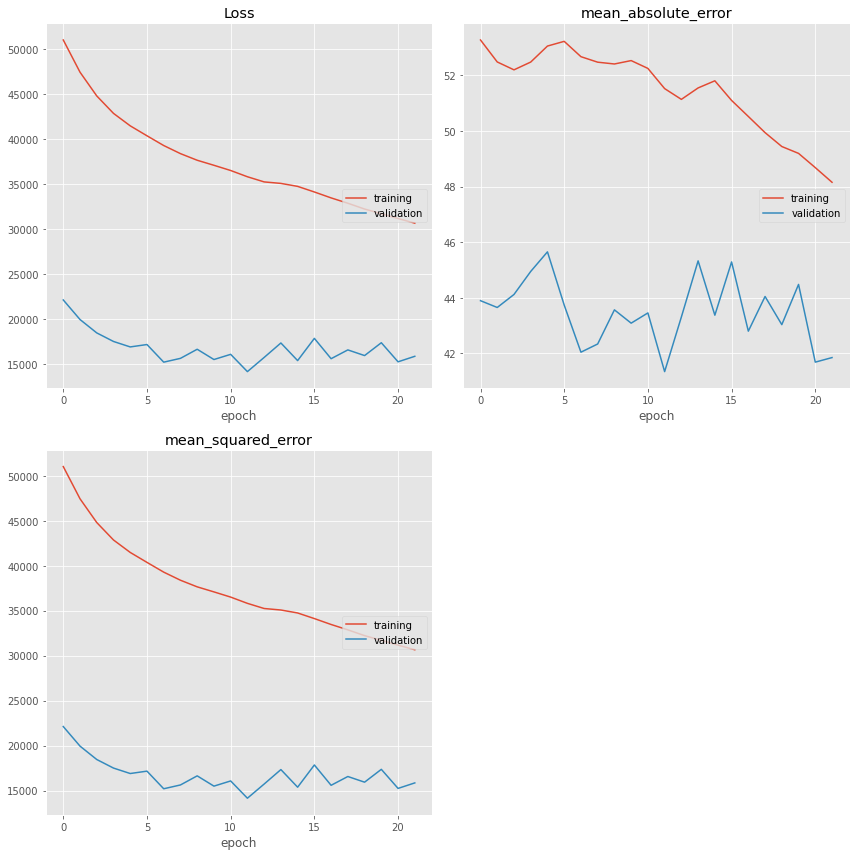

5/5 [==============================] - 0s 57ms/step
Accuracy:  63.5538%

 	 RMSE: 20.914111051540665, MAE: 15.575101534153045

 --- Overall Score --- 
	18.244606292846854
    
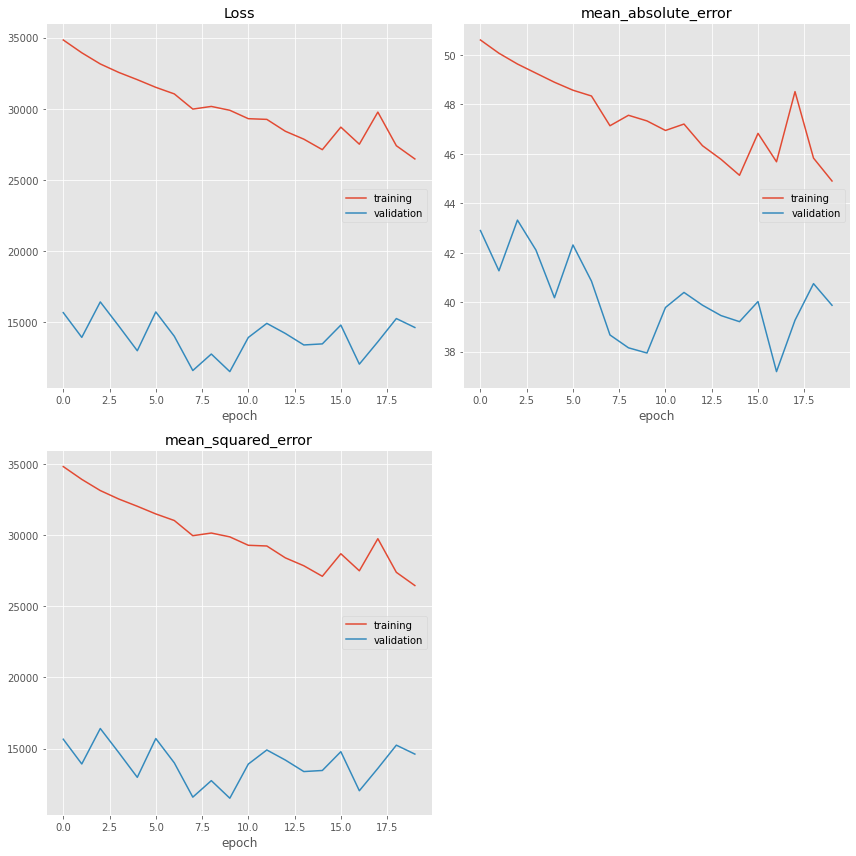


### countinued with larger validation set

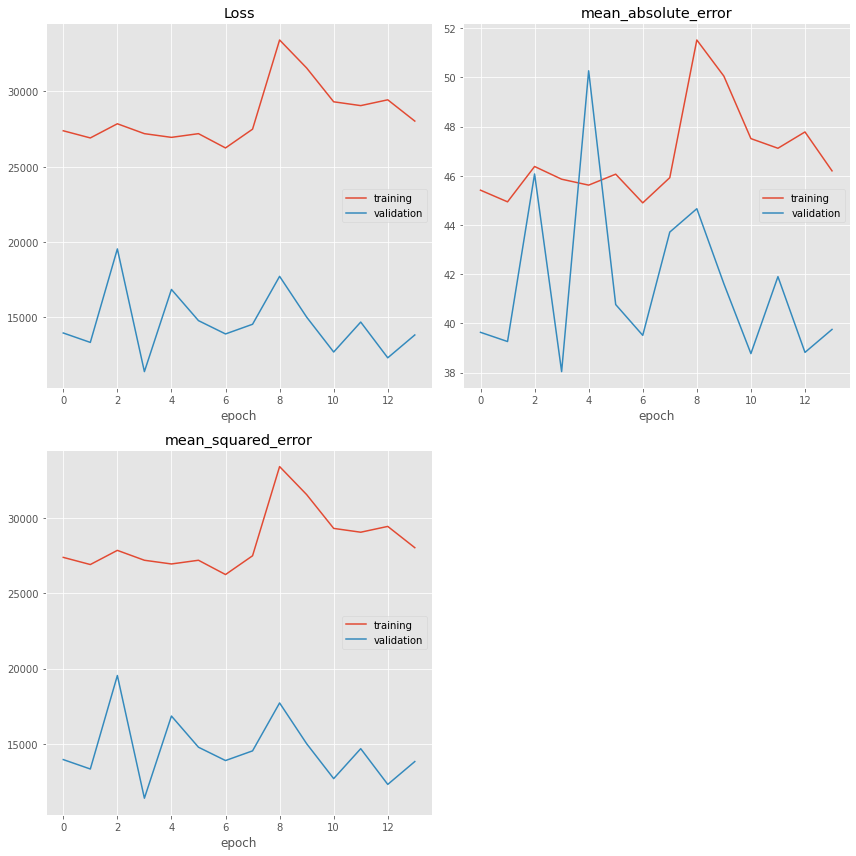

5/5 [==============================] - 0s 50ms/step
Accuracy:  65.3303%

 	 RMSE: 21.09188864577762, MAE: 16.1191686469215

 --- Overall Score --- 
	18.605528646349562

## Encoder-Decoder 288in 288 out 
## Epoch : 100